TODO: 在给定未来某个解（solution word）时，预测那天成绩分布（1,2,3,4,5,6,X 的百分比），并量化不确定性，给出 EERIE 在 2023-03-01 的预测示例

For a given future solution word on a future date, develop a model that allows you to predict the distribution of the reported results. In other words, to predict the associated percentages of (1, 2, 3, 4, 5, 6, X) for a future date. 
What uncertainties are associated with your model and predictions? Give a specific example of your prediction for the word EERIE on March 1, 2023. How confident are you in your model’s prediction?

# 模型预测——softmax回归

通过模型对比，发现softmax回归显著优于其它模型，故在此对其进行特殊优化

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

from util.visualizations import (
    plot_training_history,
    plot_random_sample_distributions,
    plot_error_analysis,
    plot_uncertainty,
    plot_performance_metrics,
    plot_comprehensive_summary,
)

# 设置中文字体和样式
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

In [2]:
# 参数设置
DATA_PATH = "data/mcm_processed_data.csv"          # 你的训练数据（包含特征 + 7维分布 + N）
N_COL = "number_of_reported_results" # 总人数列名：请改成你数据中的实际列名（如果没有就设为 None）

# 用于预测的特征列
feature_cols = [
    'Zipf-value',
    'letter_entropy',
    'feedback_entropy',
    'max_consecutive_vowels',
    'letter_freq_mean',
    'scrabble_score',
    'has_common_suffix',
    'num_rare_letters',
    'position_rarity',
    'positional_freq_min',
    'hamming_neighbors',
    'keyboard_distance',
    'semantic_distance',
    '1_try_simulate_random', '2_try_simulate_random', '3_try_simulate_random',
    '4_try_simulate_random', '5_try_simulate_random', '6_try_simulate_random', '7_try_simulate_random',
    '1_try_simulate_freq', '2_try_simulate_freq', '3_try_simulate_freq',
    '4_try_simulate_freq', '5_try_simulate_freq', '6_try_simulate_freq', '7_try_simulate_freq',
    '1_try_simulate_entropy', '2_try_simulate_entropy', '3_try_simulate_entropy',
    '4_try_simulate_entropy', '5_try_simulate_entropy', '6_try_simulate_entropy', '7_try_simulate_entropy',
    'rl_1_try_low_training', 'rl_2_try_low_training', 'rl_3_try_low_training',
    'rl_4_try_low_training', 'rl_5_try_low_training', 'rl_6_try_low_training', 'rl_7_try_low_training',
    'rl_1_try_high_training', 'rl_2_try_high_training', 'rl_3_try_high_training',
    'rl_4_try_high_training', 'rl_5_try_high_training', 'rl_6_try_high_training', 'rl_7_try_high_training',
    'rl_1_try_little_training', 'rl_2_try_little_training', 'rl_3_try_little_training',
    'rl_4_try_little_training', 'rl_5_try_little_training', 'rl_6_try_little_training', 'rl_7_try_little_training',
]

# 你给定的 7 维分布列（比例）
dist_cols = [
    "1_try", "2_tries", "3_tries", "4_tries",
    "5_tries", "6_tries", "7_or_more_tries_x"
]

RANDOM_SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# 训练超参
LR = 1e-2
WEIGHT_DECAY = 1e-4
MAX_EPOCHS = 500
PATIENCE = 30

# 加权方式：可选 "sqrt" 或 "log1p"
WEIGHT_MODE = "sqrt"

In [3]:
# 取出特征 X
df = pd.read_csv(DATA_PATH)

X = df[feature_cols].copy()
# 数值缺失值用中位数填充（ML/NN 常规做法）
X = X.fillna(X.median(numeric_only=True))

# 取出真实分布 P（7维）
P = df[dist_cols].copy()
# 分布缺失值先填 0（再统一归一化）
P = P.fillna(0.0)

# 分布转成比例
if P.to_numpy().max() > 1.5:
    P = P / 100.0

# 防止舍入误差导致每行和不为1：重新归一化
P = P.clip(lower=0.0)
row_sum = P.sum(axis=1).replace(0, np.nan)
P = P.div(row_sum, axis=0).fillna(1.0 / len(dist_cols))

# 取出权重 N（如果有）
if N_COL is not None and N_COL in df.columns:
    N = df[N_COL].copy()
    # 缺失填中位数，避免权重为 NaN
    N = N.fillna(N.median())
    # 避免出现非正数
    N = N.clip(lower=1)
else:
    N = None  # 没有总人数列就不加权

In [4]:
# 划分数据集
X_np = X.to_numpy().astype(np.float32)
P_np = P.to_numpy().astype(np.float32)

if N is not None:
    N_np = N.to_numpy().astype(np.float32)
else:
    N_np = None

# 先划分出临时集，再一分为二得到 val/test
if N_np is None:
    X_train, X_tmp, P_train, P_tmp = train_test_split(
        X_np, P_np, test_size=0.3, random_state=RANDOM_SEED
    )
    X_val, X_test, P_val, P_test = train_test_split(
        X_tmp, P_tmp, test_size=0.5, random_state=RANDOM_SEED
    )
else:
    X_train, X_tmp, P_train, P_tmp, N_train, N_tmp = train_test_split(
        X_np, P_np, N_np, test_size=0.3, random_state=RANDOM_SEED
    )
    X_val, X_test, P_val, P_test, N_val, N_test = train_test_split(
        X_tmp, P_tmp, N_tmp, test_size=0.5, random_state=RANDOM_SEED
    )

In [5]:
# 标准化特征
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_val   = scaler.transform(X_val).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

## Linear + Softmax

In [6]:
# 定义回归模型
class SoftmaxRegression(nn.Module):
    def __init__(self, d_in, n_out=7):
        super().__init__()
        self.linear = nn.Linear(d_in, n_out)

    def forward(self, x):
        logits = self.linear(x)
        p_hat = F.softmax(logits, dim=1)
        return p_hat

## MLP + Softmax

In [7]:
class MLPSoftmaxRegression(nn.Module):
    """
    MLP + Softmax：
    1) 先用隐藏层做非线性特征组合（捕捉交互/阈值效应）
    2) 再输出7维logits，经softmax转为概率分布
    """
    def __init__(self, d_in, hidden_dim=32, n_out=7, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(d_in, hidden_dim)
        self.dropout = nn.Dropout(dropout)   # 小样本可适度dropout防过拟合
        self.fc2 = nn.Linear(hidden_dim, n_out)

    def forward(self, x):
        h = F.relu(self.fc1(x))              # 非线性变换（阈值/分段线性）
        h = self.dropout(h)                  # 随机失活，提升泛化
        logits = self.fc2(h)                 # 输出logits
        p_hat = F.softmax(logits, dim=1)     # 转成7维概率分布（和为1）
        return p_hat


In [8]:
# 定义加权交叉熵损失函数

# 区分加权和不加权的函数
def make_weights_from_N(N_array, mode="sqrt"):
    """
    将总人数 N 映射为权重 w（温和变换，避免极端 N 支配训练）
    mode:
      - "sqrt":  w = sqrt(N)
      - "log1p": w = log(1+N)
    """
    if mode == "sqrt":
        w = np.sqrt(N_array)
    elif mode == "log1p":
        w = np.log1p(N_array)
    else:
        raise ValueError("mode must be 'sqrt' or 'log1p'")
    # 归一化权重（让平均权重=1），这样学习率不必重新调
    w = w / (w.mean() + 1e-12)
    return w.astype(np.float32)

def soft_cross_entropy(p_hat, p_true, eps=1e-12):
    """不加权软标签交叉熵"""
    p_hat = torch.clamp(p_hat, eps, 1.0)
    return -(p_true * torch.log(p_hat)).sum(dim=1).mean()

def weighted_soft_cross_entropy(p_hat, p_true, w, eps=1e-12):
    """加权软标签交叉熵：w shape=(batch,)"""
    p_hat = torch.clamp(p_hat, eps, 1.0)
    per_sample = -(p_true * torch.log(p_hat)).sum(dim=1)  # (batch,)
    return (w * per_sample).mean()

In [9]:
# 训练准备： 把 numpy 数据转成 torch 张量
Xtr = torch.tensor(X_train, device=DEVICE)
Ptr = torch.tensor(P_train, device=DEVICE)
Xva = torch.tensor(X_val, device=DEVICE)
Pva = torch.tensor(P_val, device=DEVICE)

if N is not None:
    w_train = make_weights_from_N(N_train, mode=WEIGHT_MODE)
    w_val   = make_weights_from_N(N_val,   mode=WEIGHT_MODE)
    Wtr = torch.tensor(w_train, device=DEVICE)
    Wva = torch.tensor(w_val,   device=DEVICE)
else:
    Wtr = None
    Wva = None

model = SoftmaxRegression(d_in=X_train.shape[1], n_out=7).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

In [10]:
# 训练循环 + 验证集早停（记录训练历史用于可视化）
best_state = None
best_val_loss = float("inf")
bad = 0

# 记录训练历史
train_losses = []
val_losses = []

for epoch in range(1, MAX_EPOCHS + 1):
    model.train()
    p_hat = model(Xtr)

    # 训练损失：有 N 就用加权版，没有 N 就用普通版
    if Wtr is None:
        loss = soft_cross_entropy(p_hat, Ptr)
    else:
        loss = weighted_soft_cross_entropy(p_hat, Ptr, Wtr)

    opt.zero_grad()
    loss.backward()
    opt.step()

    # 验证
    model.eval()
    with torch.no_grad():
        p_val = model(Xva)
        if Wva is None:
            val_loss = soft_cross_entropy(p_val, Pva).item()
        else:
            # 验证集也可加权，用同样逻辑衡量"可靠度加权的拟合质量"
            val_loss = weighted_soft_cross_entropy(p_val, Pva, Wva).item()

    # 记录损失
    train_losses.append(loss.item())
    val_losses.append(val_loss)

    # 早停判断
    if val_loss < best_val_loss - 1e-6:
        best_val_loss = val_loss
        best_state = copy.deepcopy(model.state_dict())
        bad = 0
    else:
        bad += 1

    if epoch % 50 == 0:
        print(f"epoch={epoch:3d} train_loss={loss.item():.4f} val_loss={val_loss:.4f}")

    if bad >= PATIENCE:
        print(f"Early stopping at epoch {epoch}.")
        break

# 恢复验证集最佳参数
model.load_state_dict(best_state)
print(f"Training completed. Best validation loss: {best_val_loss:.4f}")

epoch= 50 train_loss=1.6843 val_loss=1.7102
epoch=100 train_loss=1.6052 val_loss=1.6319
epoch=150 train_loss=1.5771 val_loss=1.6066
epoch=200 train_loss=1.5648 val_loss=1.5970
epoch=250 train_loss=1.5584 val_loss=1.5928
epoch=300 train_loss=1.5547 val_loss=1.5907
epoch=350 train_loss=1.5523 val_loss=1.5895
epoch=400 train_loss=1.5508 val_loss=1.5888
epoch=450 train_loss=1.5497 val_loss=1.5883
epoch=500 train_loss=1.5489 val_loss=1.5879
Training completed. Best validation loss: 1.5879


In [11]:
# 在测试集上评估 (MAE + KL)
Xte = torch.tensor(X_test, device=DEVICE)
Pte = torch.tensor(P_test, device=DEVICE)

model.eval()
with torch.no_grad():
    P_pred = model(Xte).cpu().numpy()

# MAE：7 个桶的绝对误差平均
mae = np.mean(np.abs(P_pred - P_test))

# KL(p||q)：分布差异（越小越好）
eps = 1e-12
kl = np.mean(np.sum(P_test * (np.log(P_test + eps) - np.log(P_pred + eps)), axis=1))

print("Test mean absolute error over 7 bins:", mae)
print("Test mean KL(p||q):", kl)

Test mean absolute error over 7 bins: 0.03330265
Test mean KL(p||q): 0.5215402


In [12]:
pred_df = pd.DataFrame(P_pred, columns=[f"pred_{c}" for c in dist_cols])
pred_df.to_csv("softmax_weighted_pred_output.csv", index=False)
print("Saved: softmax_weighted_pred_output.csv")

Saved: softmax_weighted_pred_output.csv


In [13]:
# MLPSoftmax 回归训练
MLP_HIDDEN = 64
MLP_DROPOUT = 0.1

mlp_model = MLPSoftmaxRegression(
    d_in=X_train.shape[1], hidden_dim=MLP_HIDDEN, n_out=7, dropout=MLP_DROPOUT
).to(DEVICE)
mlp_opt = torch.optim.Adam(mlp_model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

mlp_best_state = None
mlp_best_val_loss = float("inf")
mlp_bad = 0

mlp_train_losses = []
mlp_val_losses = []

for epoch in range(1, MAX_EPOCHS + 1):
    mlp_model.train()
    mlp_p_hat = mlp_model(Xtr)

    if Wtr is None:
        mlp_loss = soft_cross_entropy(mlp_p_hat, Ptr)
    else:
        mlp_loss = weighted_soft_cross_entropy(mlp_p_hat, Ptr, Wtr)

    mlp_opt.zero_grad()
    mlp_loss.backward()
    mlp_opt.step()

    mlp_model.eval()
    with torch.no_grad():
        mlp_p_val = mlp_model(Xva)
        if Wva is None:
            mlp_val_loss = soft_cross_entropy(mlp_p_val, Pva).item()
        else:
            mlp_val_loss = weighted_soft_cross_entropy(mlp_p_val, Pva, Wva).item()

    mlp_train_losses.append(mlp_loss.item())
    mlp_val_losses.append(mlp_val_loss)

    if mlp_val_loss < mlp_best_val_loss - 1e-6:
        mlp_best_val_loss = mlp_val_loss
        mlp_best_state = copy.deepcopy(mlp_model.state_dict())
        mlp_bad = 0
    else:
        mlp_bad += 1

    if epoch % 50 == 0:
        print(
            f"[MLP] epoch={epoch:3d} train_loss={mlp_loss.item():.4f} val_loss={mlp_val_loss:.4f}"
        )

    if mlp_bad >= PATIENCE:
        print(f"[MLP] Early stopping at epoch {epoch}.")
        break

mlp_model.load_state_dict(mlp_best_state)
print(f"[MLP] Training completed. Best validation loss: {mlp_best_val_loss:.4f}")


[MLP] epoch= 50 train_loss=1.5412 val_loss=1.5887
[MLP] Early stopping at epoch 67.
[MLP] Training completed. Best validation loss: 1.5829


In [14]:
# MLPSoftmax 测试集评估与输出
Xte_mlp = torch.tensor(X_test, device=DEVICE)
Pte_mlp = torch.tensor(P_test, device=DEVICE)

mlp_model.eval()
with torch.no_grad():
    mlp_P_pred = mlp_model(Xte_mlp).cpu().numpy()

mlp_mae = np.mean(np.abs(mlp_P_pred - P_test))
mlp_eps = 1e-12
mlp_kl = np.mean(
    np.sum(P_test * (np.log(P_test + mlp_eps) - np.log(mlp_P_pred + mlp_eps)), axis=1)
)

print("[MLP] Test mean absolute error over 7 bins:", mlp_mae)
print("[MLP] Test mean KL(p||q):", mlp_kl)

mlp_pred_df = pd.DataFrame(mlp_P_pred, columns=[f"mlp_pred_{c}" for c in dist_cols])
mlp_pred_df.to_csv("mlp_softmax_pred_output.csv", index=False)
print("Saved: mlp_softmax_pred_output.csv")


[MLP] Test mean absolute error over 7 bins: 0.03213357
[MLP] Test mean KL(p||q): 0.39421743
Saved: mlp_softmax_pred_output.csv


### MLPSoftmax 回归：可视化与对比


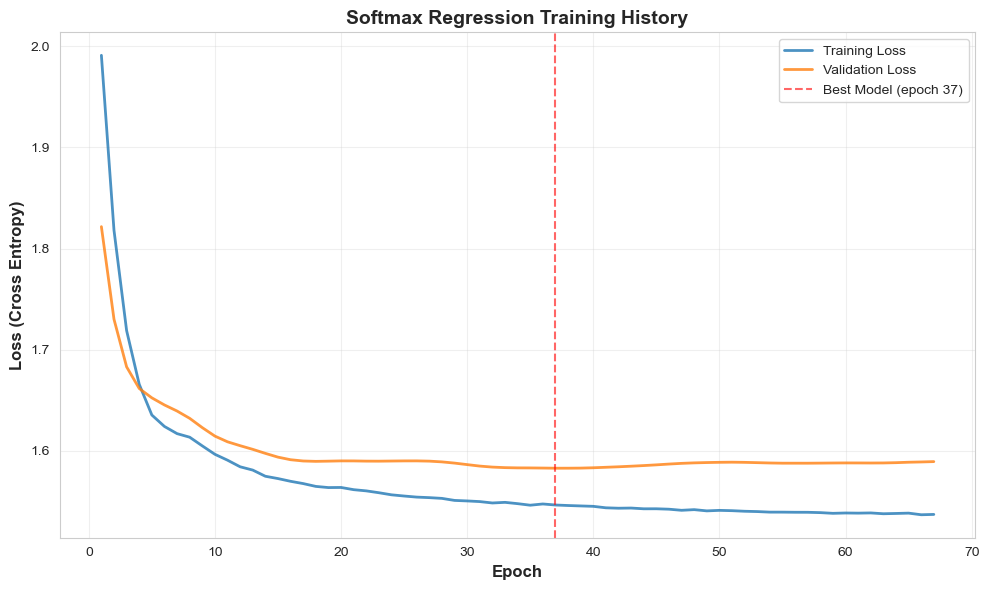

[MLP] 训练结束于第 67 轮
[MLP] 最佳模型来自第 37 轮
[MLP] 最终训练损失: 1.5372
[MLP] 最佳验证损失: 1.5829


In [15]:
# 1) 训练曲线
mlp_history_info = plot_training_history(
    train_losses=mlp_train_losses,
    val_losses=mlp_val_losses,
    bad=mlp_bad,
    best_val_loss=mlp_best_val_loss,
    save_path="mlp_softmax_training_history.png",
)

print(f"[MLP] 训练结束于第 {len(mlp_train_losses)} 轮")
print(f"[MLP] 最佳模型来自第 {mlp_history_info['best_epoch']} 轮")
print(f"[MLP] 最终训练损失: {mlp_history_info['final_train_loss']:.4f}")
print(f"[MLP] 最佳验证损失: {mlp_history_info['best_val_loss']:.4f}")


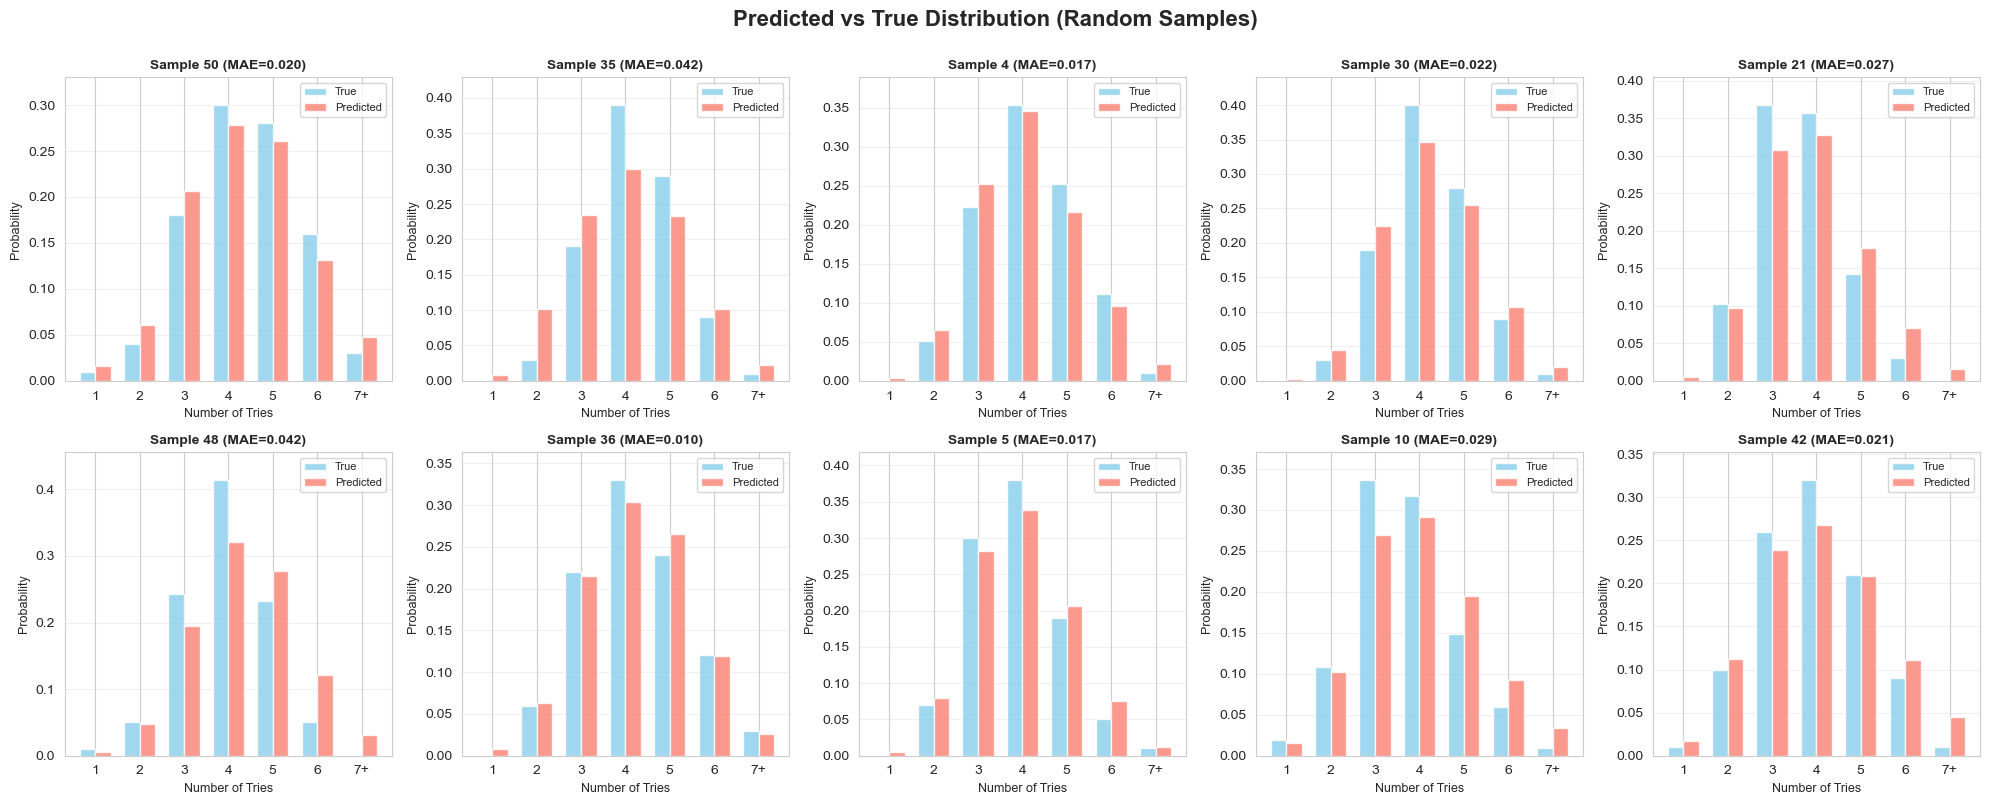

[MLP] sample indices: [50 35  4 30 21 48 36  5 10 42]


In [16]:
# 2) 预测 vs 真实分布
mlp_sample_indices = plot_random_sample_distributions(
    P_test=P_test,
    P_pred=mlp_P_pred,
    sample_size=10,
    save_path="mlp_softmax_distribution_comparison.png",
)
print("[MLP] sample indices:", mlp_sample_indices)


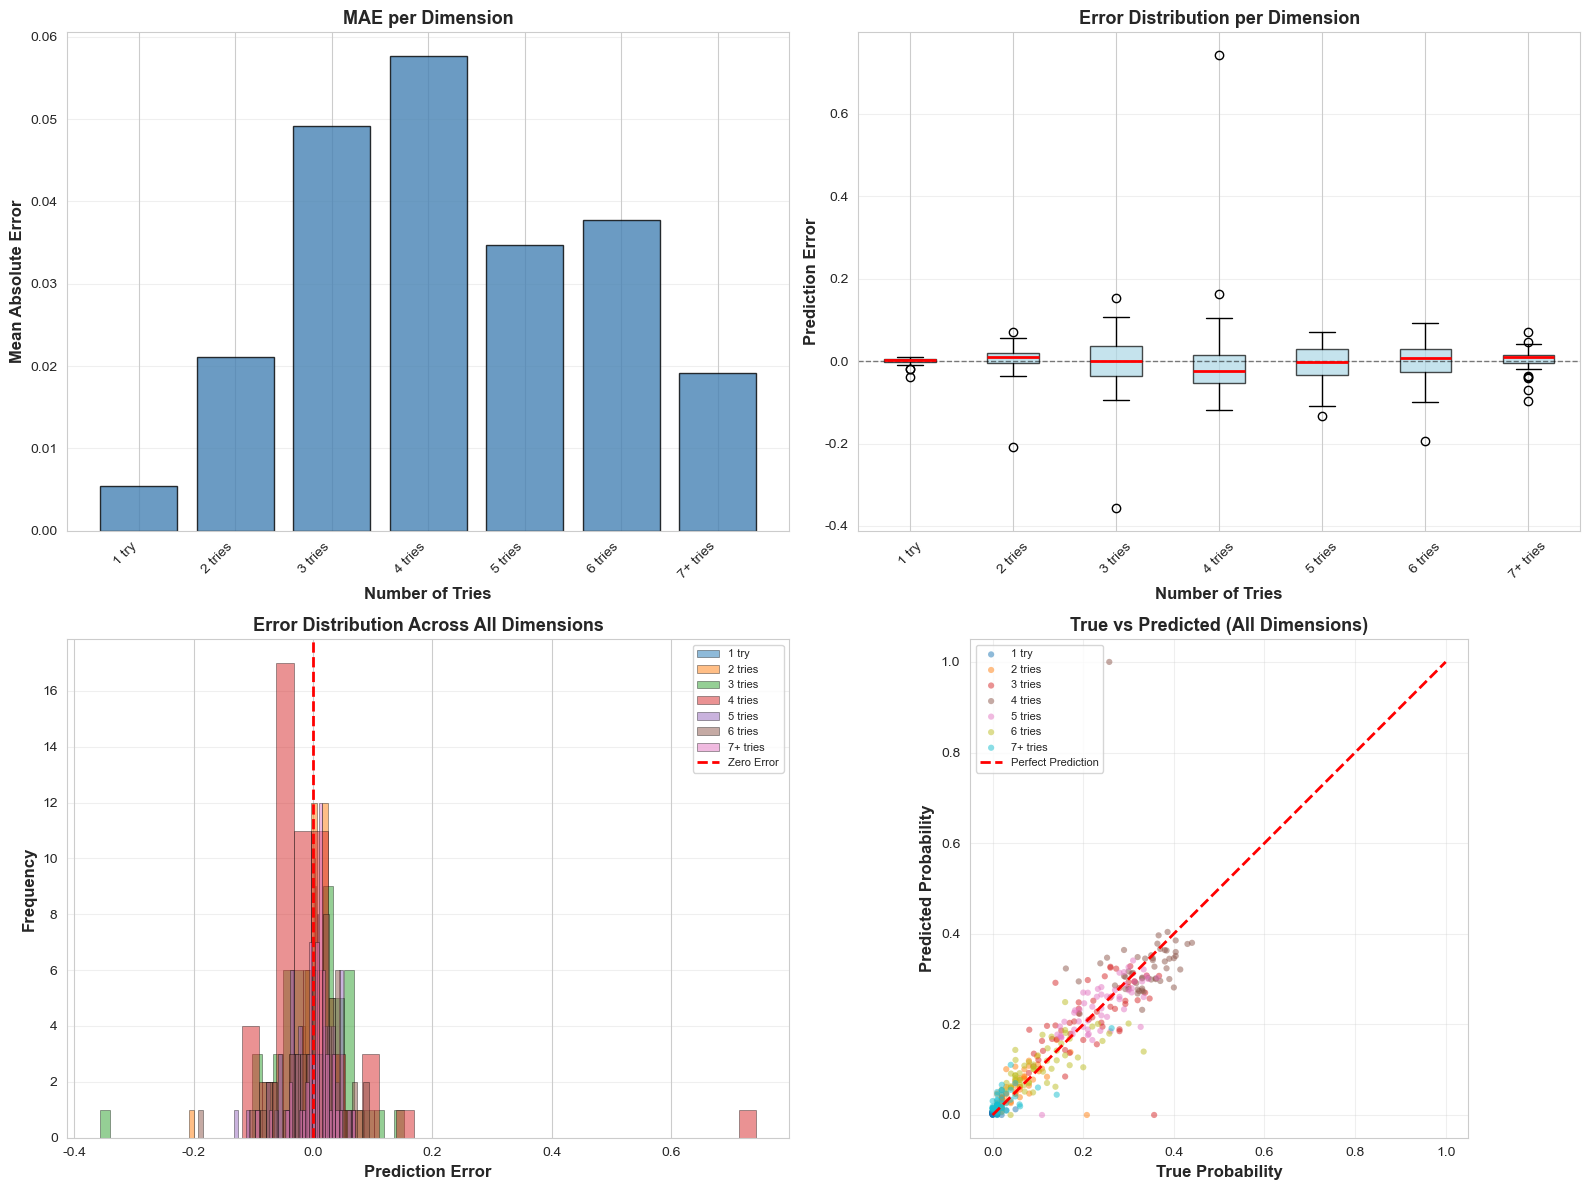

[MLP] 各维度误差统计:

1 try:
  MAE:  0.0055
  Mean Error: 0.0004
  Std Error:  0.0080
  Max |Error|: 0.0380

2 tries:
  MAE:  0.0211
  Mean Error: 0.0052
  Std Error:  0.0358
  Max |Error|: 0.2079

3 tries:
  MAE:  0.0491
  Mean Error: -0.0024
  Std Error:  0.0715
  Max |Error|: 0.3564

4 tries:
  MAE:  0.0576
  Mean Error: -0.0029
  Std Error:  0.1152
  Max |Error|: 0.7426

5 tries:
  MAE:  0.0347
  Mean Error: -0.0042
  Std Error:  0.0427
  Max |Error|: 0.1324

6 tries:
  MAE:  0.0377
  Mean Error: -0.0015
  Std Error:  0.0506
  Max |Error|: 0.1934

7+ tries:
  MAE:  0.0191
  Mean Error: 0.0055
  Std Error:  0.0262
  Max |Error|: 0.0967


In [17]:
# 3) 误差分析
mlp_error_stats = plot_error_analysis(
    P_test=P_test,
    P_pred=mlp_P_pred,
    save_path="mlp_softmax_error_analysis_per_dimension.png",
)

mlp_errors = mlp_error_stats["errors"]
mlp_abs_errors = mlp_error_stats["abs_errors"]
mlp_mae_per_dim = mlp_error_stats["mae_per_dim"]
mlp_dim_names = ['1 try', '2 tries', '3 tries', '4 tries', '5 tries', '6 tries', '7+ tries']

print("=" * 80)
print("[MLP] 各维度误差统计:")
print("=" * 80)
for i, name in enumerate(mlp_dim_names):
    print(f"\n{name}:")
    print(f"  MAE:  {mlp_mae_per_dim[i]:.4f}")
    print(f"  Mean Error: {mlp_errors[:, i].mean():.4f}")
    print(f"  Std Error:  {mlp_errors[:, i].std():.4f}")
    print(f"  Max |Error|: {mlp_abs_errors[:, i].max():.4f}")


[MLP] 正在进行 Bootstrap 预测... (这可能需要一些时间)


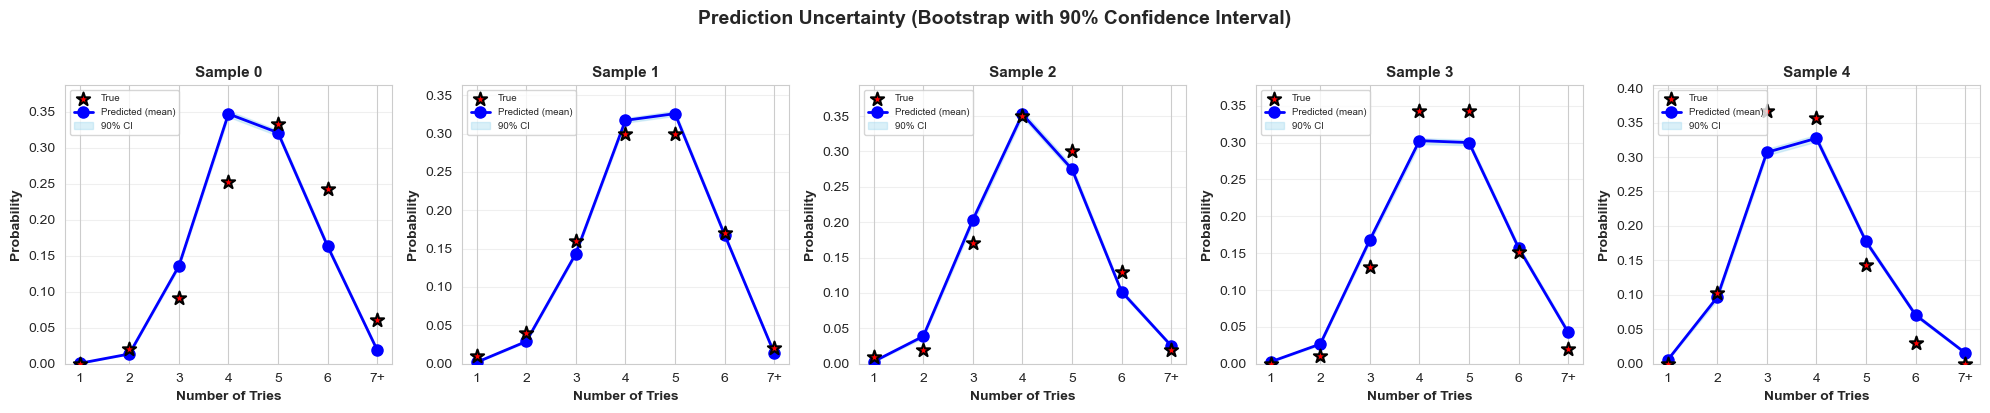


[MLP] 预测不确定性统计 (基于 Bootstrap):
平均标准差:   0.0017
最大标准差:   0.0032
平均置信区间宽度: 0.0054


In [18]:
# 4) 不确定性量化
print("[MLP] 正在进行 Bootstrap 预测... (这可能需要一些时间)")
mlp_sample_indices_unc = np.random.choice(len(X_test), size=min(5, len(X_test)), replace=False)
mlp_X_samples = X_test[mlp_sample_indices_unc]
mlp_P_samples_true = P_test[mlp_sample_indices_unc]

mlp_uncertainty_stats = plot_uncertainty(
    model=mlp_model,
    X_samples=mlp_X_samples,
    P_samples_true=mlp_P_samples_true,
    device=DEVICE,
    n_bootstrap=100,
    save_path="mlp_softmax_uncertainty_quantification.png",
)

print("\n" + "=" * 80)
print("[MLP] 预测不确定性统计 (基于 Bootstrap):")
print("=" * 80)
print(f"平均标准差:   {mlp_uncertainty_stats['avg_std']:.4f}")
print(f"最大标准差:   {mlp_uncertainty_stats['max_std']:.4f}")
print(f"平均置信区间宽度: {mlp_uncertainty_stats['avg_ci_width']:.4f}")
print("=" * 80)


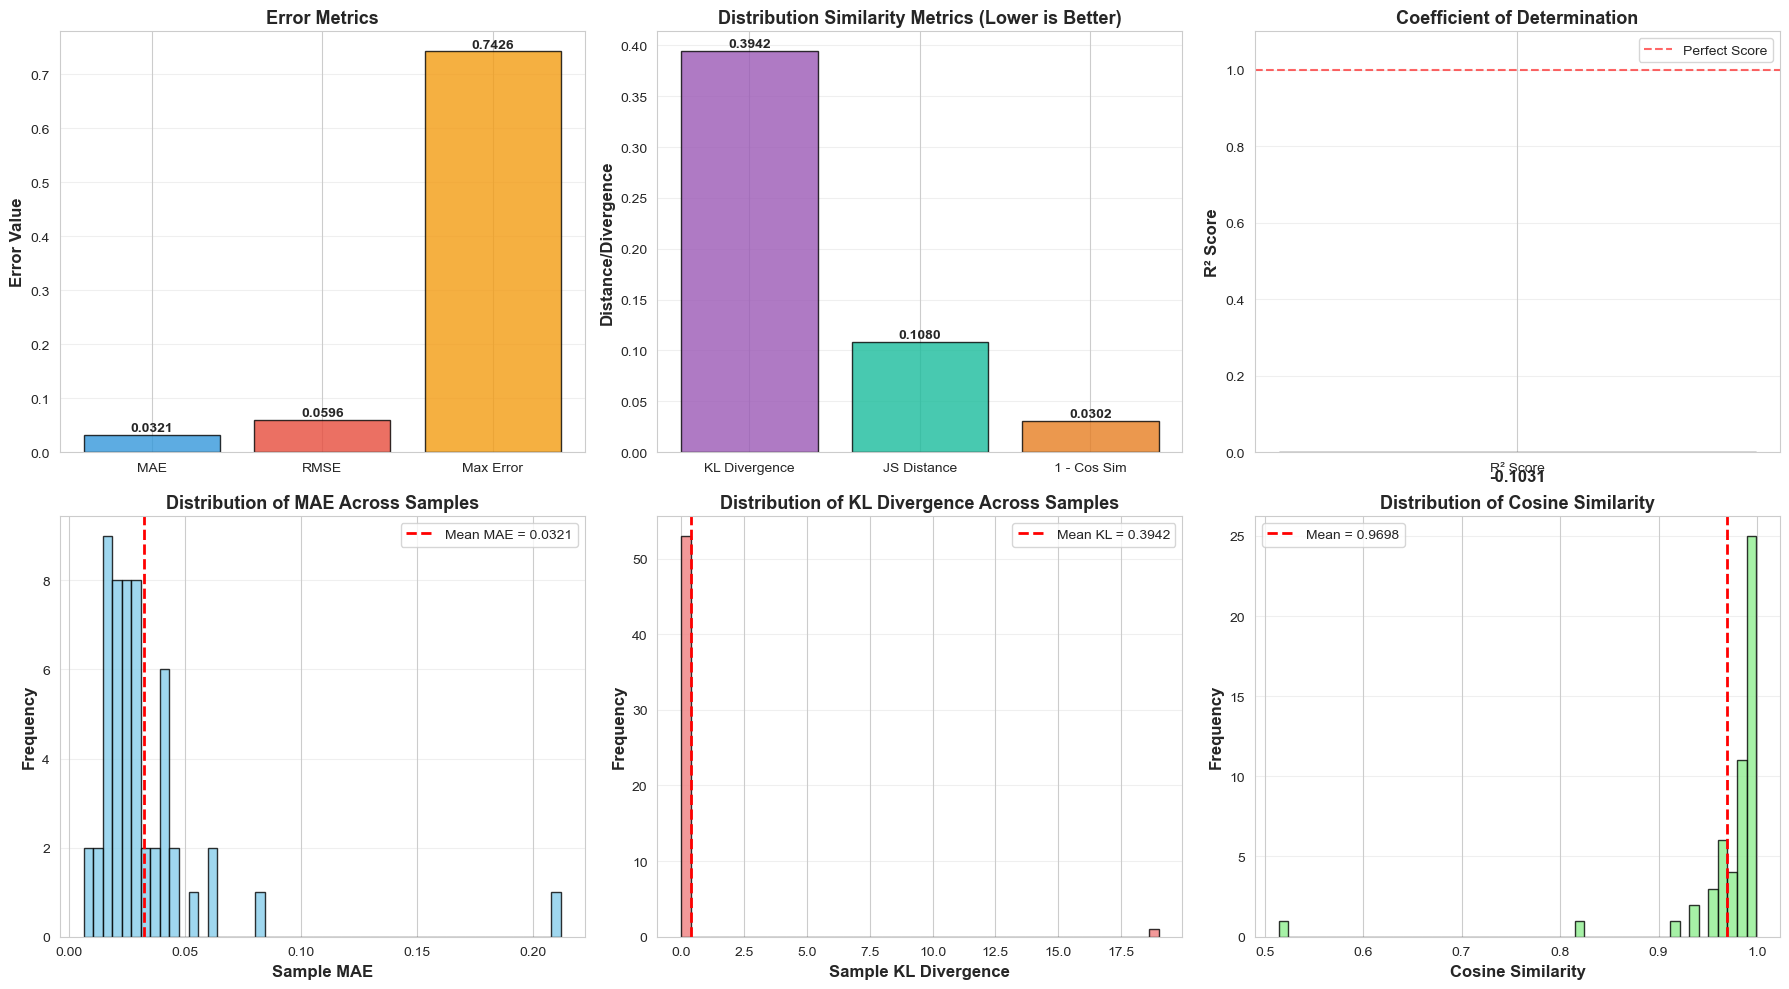


[MLP] Softmax Regression Model - 综合评估报告

误差指标:
  MAE (Mean Absolute Error):     0.032134
  RMSE (Root Mean Squared Error): 0.059629
  Max Error:                      0.742574

分布相似度指标:
  KL Divergence:                  0.394217
  JS Distance:                    0.108013
  Cosine Similarity:              0.969828

拟合质量:
  R² Score:                       -0.103147



In [19]:
# 5) 整体性能指标
mlp_metrics = plot_performance_metrics(
    P_test=P_test,
    P_pred=mlp_P_pred,
    save_path="mlp_softmax_performance_metrics.png",
)

mlp_rmse = mlp_metrics["rmse"]
mlp_js_mean = mlp_metrics["js_mean"]
mlp_cos_sim = mlp_metrics["cos_sim"]
mlp_r2 = mlp_metrics["r2"]
mlp_max_error = mlp_metrics["max_error"]

print("\n" + "=" * 80)
print("[MLP] Softmax Regression Model - 综合评估报告")
print("=" * 80)
print(f"\n误差指标:")
print(f"  MAE (Mean Absolute Error):     {mlp_mae:.6f}")
print(f"  RMSE (Root Mean Squared Error): {mlp_rmse:.6f}")
print(f"  Max Error:                      {mlp_max_error:.6f}")
print(f"\n分布相似度指标:")
print(f"  KL Divergence:                  {mlp_kl:.6f}")
print(f"  JS Distance:                    {mlp_js_mean:.6f}")
print(f"  Cosine Similarity:              {mlp_cos_sim:.6f}")
print(f"\n拟合质量:")
print(f"  R² Score:                       {mlp_r2:.6f}")
print("\n" + "=" * 80)


/Users/luoyiti/Project/MCM_2023_C/util/visualizations.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


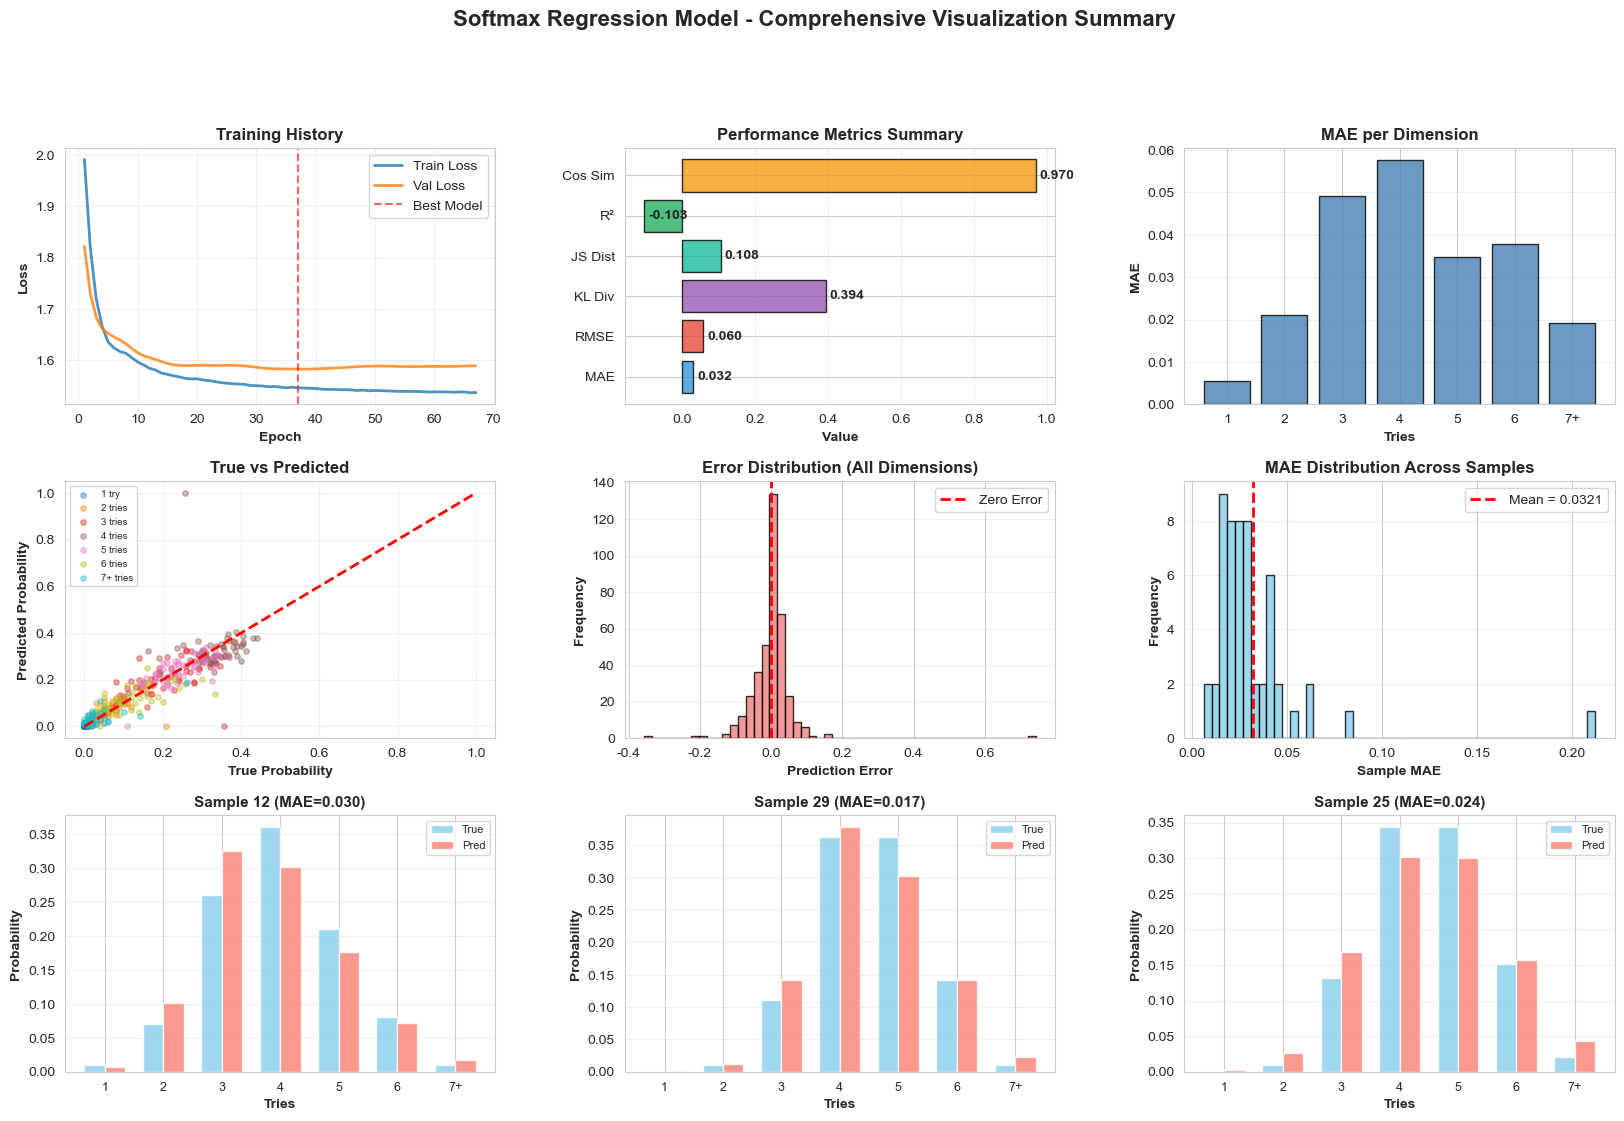

[MLP] 综合可视化完成，生成 mlp_softmax_comprehensive_summary.png


In [20]:
# 6) 综合可视化汇总
mlp_summary_info = plot_comprehensive_summary(
    train_losses=mlp_train_losses,
    val_losses=mlp_val_losses,
    bad=mlp_bad,
    best_val_loss=mlp_best_val_loss,
    mae=mlp_mae,
    rmse=mlp_rmse,
    kl=mlp_kl,
    js_mean=mlp_js_mean,
    cos_sim=mlp_cos_sim,
    r2=mlp_r2,
    mae_per_dim=mlp_mae_per_dim,
    P_test=P_test,
    P_pred=mlp_P_pred,
    errors=mlp_errors,
    save_path="mlp_softmax_comprehensive_summary.png",
)

print("[MLP] 综合可视化完成，生成 mlp_softmax_comprehensive_summary.png")


### 1. 训练过程可视化 - 损失曲线

## 可视化分析

以下对训练好的 Softmax 模型进行全面的可视化分析，包括：
1. 训练过程可视化（损失曲线）
2. 预测与真实分布对比
3. 各维度误差分析
4. 性能指标可视化
5. 不确定性量化
6. 案例研究

### 2. 预测 vs 真实分布对比

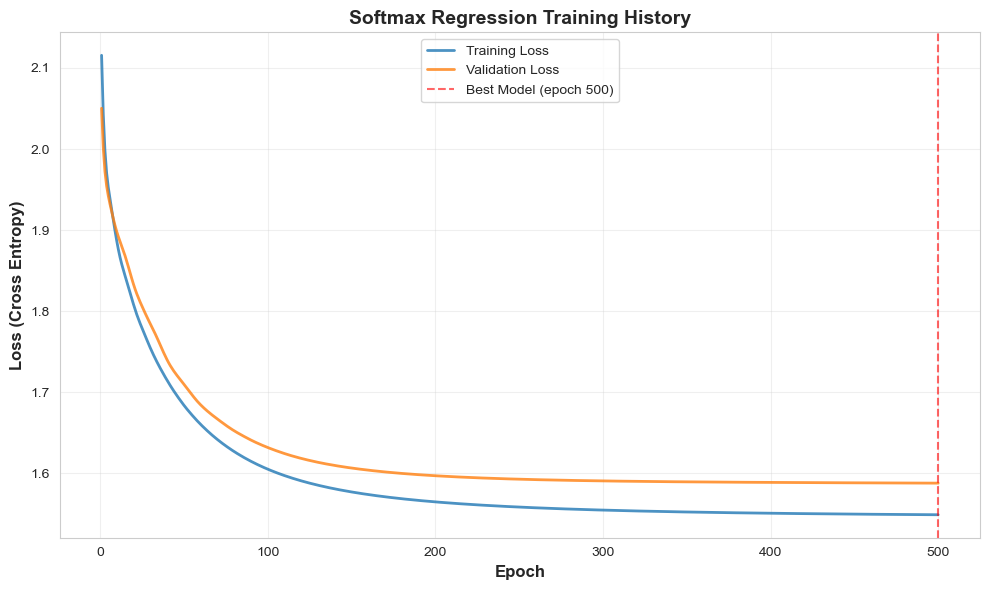

训练结束于第 500 轮
最佳模型来自第 500 轮
最终训练损失: 1.5489
最佳验证损失: 1.5879


In [22]:
history_info = plot_training_history(
    train_losses=train_losses,
    val_losses=val_losses,
    bad=bad,
    best_val_loss=best_val_loss,
)

print(f"训练结束于第 {len(train_losses)} 轮")
print(f"最佳模型来自第 {history_info['best_epoch']} 轮")
print(f"最终训练损失: {history_info['final_train_loss']:.4f}")
print(f"最佳验证损失: {history_info['best_val_loss']:.4f}")

### 3. 各维度（1-7 tries）的预测误差分析

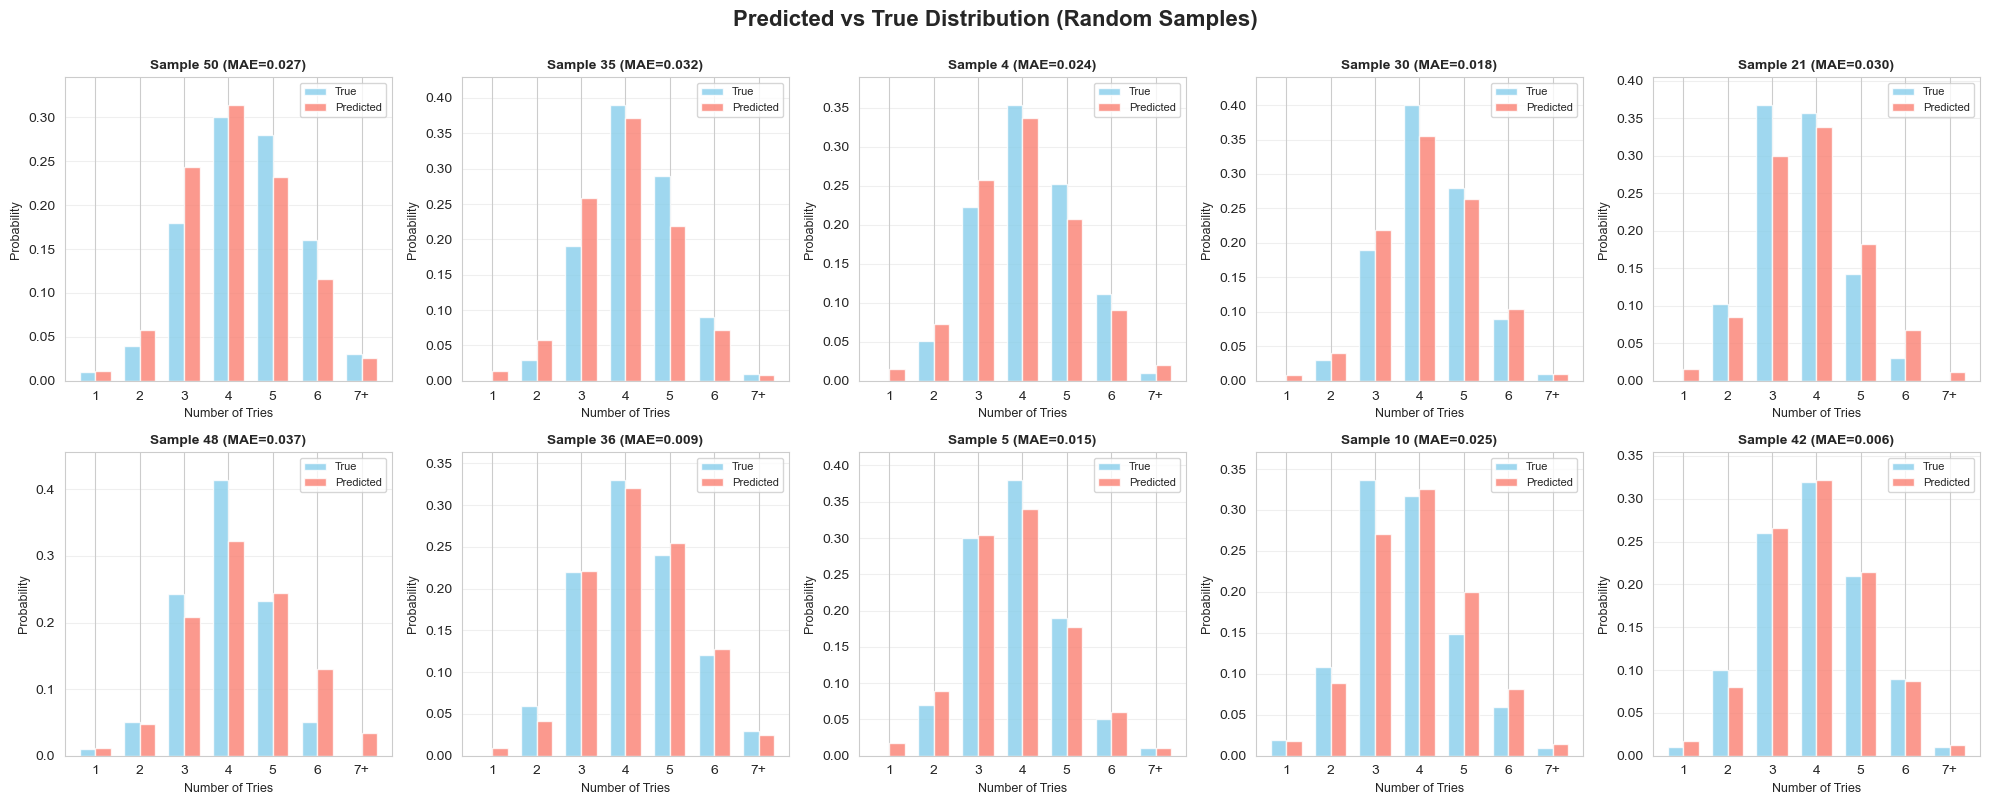

In [23]:
sample_indices = plot_random_sample_distributions(
    P_test=P_test,
    P_pred=P_pred,
    sample_size=10,
    save_path="softmax_distribution_comparison.png",
)

### 4. 整体性能指标可视化

In [ ]:
error_stats = plot_error_analysis(
    P_test=P_test,
    P_pred=P_pred,
    save_path="softmax_error_analysis_per_dimension.png",
)

errors = error_stats["errors"]
abs_errors = error_stats["abs_errors"]
mae_per_dim = error_stats["mae_per_dim"]
dim_names = ['1 try', '2 tries', '3 tries', '4 tries', '5 tries', '6 tries', '7+ tries']

print("=" * 80)
print("各维度误差统计:")
print("=" * 80)
for i, name in enumerate(dim_names):
    print(f"\n{name}:")
    print(f"  MAE:  {mae_per_dim[i]:.4f}")
    print(f"  Mean Error: {errors[:, i].mean():.4f}")
    print(f"  Std Error:  {errors[:, i].std():.4f}")
    print(f"  Max |Error|: {abs_errors[:, i].max():.4f}")

### 5. 预测不确定性量化

通过 Bootstrap 重采样方法估计预测的置信区间

In [ ]:
print("正在进行 Bootstrap 预测... (这可能需要一些时间)")
sample_indices_unc = np.random.choice(len(X_test), size=min(5, len(X_test)), replace=False)
X_samples = X_test[sample_indices_unc]
P_samples_true = P_test[sample_indices_unc]

uncertainty_stats = plot_uncertainty(
    model=model,
    X_samples=X_samples,
    P_samples_true=P_samples_true,
    device=DEVICE,
    n_bootstrap=100,
    save_path="softmax_uncertainty_quantification.png",
)

print("\n" + "=" * 80)
print("预测不确定性统计 (基于 Bootstrap):")
print("=" * 80)
print(f"平均标准差:   {uncertainty_stats['avg_std']:.4f}")
print(f"最大标准差:   {uncertainty_stats['max_std']:.4f}")
print(f"平均置信区间宽度: {uncertainty_stats['avg_ci_width']:.4f}")
print("=" * 80)

### 6. 模型性能的热图分析

展示真实分布与预测分布的相关性

In [ ]:
metrics = plot_performance_metrics(
    P_test=P_test,
    P_pred=P_pred,
    save_path="softmax_performance_metrics.png",
)

mae = metrics["mae"]
rmse = metrics["rmse"]
kl = metrics["kl"]
js_mean = metrics["js_mean"]
cos_sim = metrics["cos_sim"]
r2 = metrics["r2"]
max_error = metrics["max_error"]

print("\n" + "=" * 80)
print("Softmax Regression Model - 综合评估报告")
print("=" * 80)
print(f"\n误差指标:")
print(f"  MAE (Mean Absolute Error):     {mae:.6f}")
print(f"  RMSE (Root Mean Squared Error): {rmse:.6f}")
print(f"  Max Error:                      {max_error:.6f}")
print(f"\n分布相似度指标:")
print(f"  KL Divergence:                  {kl:.6f}")
print(f"  JS Distance:                    {js_mean:.6f}")
print(f"  Cosine Similarity:              {cos_sim:.6f}")
print(f"\n拟合质量:")
print(f"  R² Score:                       {r2:.6f}")
print("\n" + "=" * 80)

In [ ]:
summary_info = plot_comprehensive_summary(
    train_losses=train_losses,
    val_losses=val_losses,
    bad=bad,
    best_val_loss=best_val_loss,
    mae=mae,
    rmse=rmse,
    kl=kl,
    js_mean=js_mean,
    cos_sim=cos_sim,
    r2=r2,
    mae_per_dim=mae_per_dim,
    P_test=P_test,
    P_pred=P_pred,
    errors=errors,
    save_path="softmax_comprehensive_summary.png",
)

print("\n" + "=" * 80)
print("所有可视化分析已完成！")
print("=" * 80)
print("\n生成的图片文件:")
print("  1. softmax_training_history.png - 训练历史曲线")
print("  2. softmax_distribution_comparison.png - 预测与真实分布对比")
print("  3. softmax_error_analysis_per_dimension.png - 各维度误差分析")
print("  4. softmax_performance_metrics.png - 整体性能指标")
print("  5. softmax_uncertainty_quantification.png - 不确定性量化")
print("  6. softmax_correlation_heatmap.png - 相关性热图")
print("  7. softmax_EERIE_prediction.png - EERIE 案例预测")
print("  8. softmax_comprehensive_summary.png - 综合总结")
print("=" * 80)

### 8. 综合可视化总结报告